In [1]:
import numpy as np
from scipy.special import i0, i1
from scipy.optimize import fsolve, root, minimize, LinearConstraint
import numdifftools as nd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [25]:
def dot(a, b):
    '''Calculate dot product of two 2D vectors'''
    return np.dot(a, b)

def norm(v):
    '''Calculate norm of a 2D vector'''
    return np.sqrt(v[0]**2 + v[1]**2)

def to_angle(v):
    '''Convert 2D vector to angle'''
    return np.arctan2(v[1], v[0])

def constraint_phi1(x):
    '''Constraint that phi1 is a unit vector'''
    return x[0]**2 + x[1]**2 - 1

def constraint_phi2(x):
    '''Constraint that phi2 is a unit vector'''
    return x[2]**2 + x[3]**2 - 1

def check_constraint_comp(phi1, phi2, om1, om2, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is in N(om2, theta0).'''
    return abs(phi1-om1) <= theta0 and abs(phi2-om2) <= theta0

def check_constraint_dec(phi1, phi2, om1, om2, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is not in N(om2, theta0).'''
    return abs(phi1-om1) <= theta0 and abs(phi2-om2) > theta0

def free_energy(x, T, J12, J1, J2, omega1, omega2):
    '''phi1, phi2, omega1, omega2 are components of 2D vectors.
       x is a 1D array with the components of phi1 and phi2: [phi1_x, phi1_y, phi2_x, phi2_y]'''
    phi1 = x[:2]
    phi2 = x[2:4]
    return T/J12 * dot(phi1, phi2) + J1*J2/(J12*T) * dot(omega1, omega2) - 1/J12 * (J2*dot(phi1, omega2) + J1*dot(phi2, omega1)) - np.log(i0(norm(phi1))) - np.log(i0(norm(phi2)))

def free_energy_polar(phi, T, J12, J1, J2, omega1, omega2):
    '''phi = [phi1, phi2] are angles'''
    # Convert angles to Cartesian coordinates
    phi1 = [np.cos(phi[0]), np.sin(phi[0])]
    phi2 = [np.cos(phi[1]), np.sin(phi[1])]
    return T/J12 * dot(phi1, phi2) + J1*J2/T * dot(omega1, omega2) - 1/J12 * (J2*dot(phi1, omega2) + J1*dot(phi2, omega1)) - np.log(i0(norm(phi1))) - np.log(i0(norm(phi2)))

In [26]:
def find_minima(T, J12, J1, J2, omega1, omega2):
    # initial guess
    x0 = [1.0, 0.0, 1.0, 0.0]  # phi1 and phi2 start as unit vectors

    # define constraints
    cons = [{'type':'eq', 'fun':constraint_phi1}, {'type':'eq', 'fun':constraint_phi2}]

    # find minimum
    result = minimize(free_energy, x0, args=(T, J12, J1, J2, omega1, omega2), constraints=cons)
    
    # if no result, return None
    if result.success == False:
        return None, False
    
    phi1_sol = np.arctan2(result.x[1], result.x[0])
    phi2_sol = np.arctan2(result.x[3], result.x[2])

    

    hes = nd.Hessian(lambda phi: free_energy_polar(phi, T=100, J12=100, J1=100, J2=100, omega1=omega1, omega2=omega2))([phi1_sol, phi2_sol])
    # hes = nd.Hessian(lambda phi: free_energy_polar(phi, T=100, J12=100, J1=100, J2=100, omega1=[np.cos(20), np.sin(20)], omega2=[np.cos(-20), np.sin(-20)]))([phi1_sol, phi2_sol])
    eigenvalues = np.linalg.eigvals(hes)

    # Check if it's a minimum
    # eigenvalues = np.linalg.eigvals(hes)
    if np.all(eigenvalues > 0):
        # print('The solution is a minimum.')
        return result.x, True
    elif np.all(eigenvalues < 0):
        # print('The solution is a maximum.')
        return result.x, False
    else:
        # print('The solution is a saddle point.')
        return result.x, False
    
    # return result.x, hes, eigenvalues

In [27]:
sol = find_minima(T=100, J12=100, J1=100, J2=100, omega1=[np.cos(20), np.sin(20)], omega2=[np.cos(-20), np.sin(-20)])
# check constraint for solution
print(check_constraint_comp(to_angle(sol[0][:2]), to_angle(sol[0][2:]), 20, -20, 0.1))

False


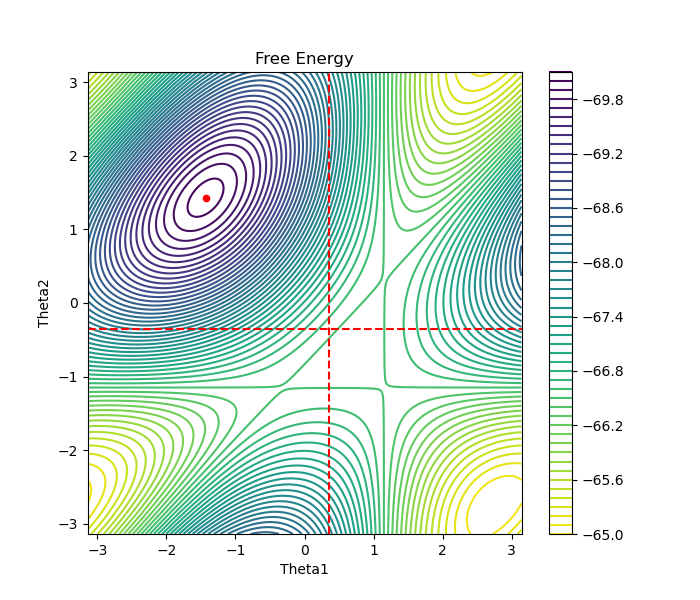

In [28]:
#PARAMETERS
omega1=[np.cos(20), np.sin(20)]
omega2=[np.cos(-20), np.sin(-20)]
T = 100
J12 = 100
J1 = 100
J2 = 100

theta1_values = np.linspace(-np.pi, np.pi, 500)
theta2_values = np.linspace(-np.pi, np.pi, 500)
theta1_grid, theta2_grid = np.meshgrid(theta1_values, theta2_values)

E_values = np.empty_like(theta1_grid)

for i in range(theta1_grid.shape[0]):
    for j in range(theta1_grid.shape[1]):
        theta = [theta1_grid[i, j], theta2_grid[i, j]]
        E_values[i, j] = free_energy_polar(theta, T, J12, J1, J2, omega1, omega2)

# Supposing `sol` is your solution
theta1_sol = np.arctan2(sol[0][1], sol[0][0])
theta2_sol = np.arctan2(sol[0][3], sol[0][2])

# Contour plot
plt.figure(figsize=(7,6))
contour = plt.contour(theta1_grid, theta2_grid, E_values, levels=50, cmap='viridis')
plt.scatter(theta1_sol, theta2_sol, color='r', s=20)  # mark the solution

# orizontal and vertical lines
plt.axhline(y=np.radians(-20), color='r', linestyle='--')
plt.axvline(x=np.radians(20), color='r', linestyle='--')

plt.colorbar(contour)
plt.title('Free Energy')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.show()

## Try to find a phase diagram

In [29]:
T = 100
J12 = 10
theta0 = np.radians(20)

om2 = 0

df_comp = pd.DataFrame(columns=['J12', 'Jmax', 'T', 'om1', 'om2', 'phi'])
df_dec = pd.DataFrame(columns=['J12', 'Jmax', 'T', 'om1', 'om2', 'phi'])

for om1 in np.arange(0, np.pi, np.pi/60):
    for Jmax in 10/np.linspace(1, 30, 50):
        om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]

        sol_comp = find_minima(T, J12, Jmax, Jmax, om[:2], om[2:])
        sol_dec = find_minima(T, J12, Jmax, Jmax, om[:2], om[2:])


        df_comp = df_comp.append({'J12':J12, 'Jmax':Jmax, 'T':T, 'om1':om1, 'om2':om2, 'phi':sol_comp[0], 'is_min':sol_comp[1]}, ignore_index=True)
        df_dec = df_dec.append({'J12':J12, 'Jmax':Jmax, 'T':T, 'om1':om1, 'om2':om2, 'phi':sol_dec[0], 'is_min':sol_dec[1]}, ignore_index=True)

/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(

In [30]:
#check if there are None values and select those rows
df_comp = df_comp[df_comp['phi'].notna()]
df_dec = df_dec[df_dec['phi'].notna()]

In [31]:



df_comp['phi1'] = df_comp.apply(lambda row: to_angle(row['phi'][:2]), axis=1)
df_comp['phi2'] = df_comp.apply(lambda row: to_angle(row['phi'][2:]), axis=1)

df_dec['phi1'] = df_dec.apply(lambda row: to_angle(row['phi'][:2]), axis=1)
df_dec['phi2'] = df_dec.apply(lambda row: to_angle(row['phi'][2:]), axis=1)

# add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om1'] - row['om2'], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om1'] - row['om2'], axis=1)

# add column is_sol
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp(row['phi1'], row['phi2'], row['om1'], row['om2'], theta0), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_dec(row['phi1'], row['phi2'], row['om1'], row['om2'], theta0), axis=1)

In [32]:
comp = df_comp[df_comp['is_sol'] == True]
dec = df_dec[df_dec['is_sol'] == True]

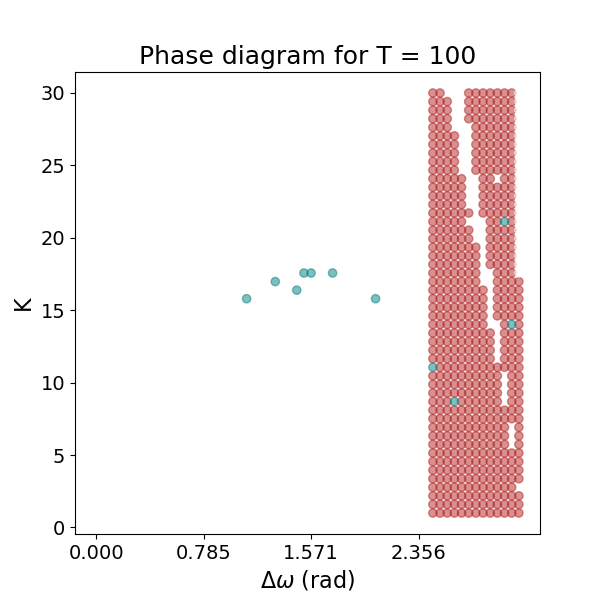

In [33]:
# Define the custom colormaps
colors1 = ListedColormap(['white', 'firebrick'])
colors2 = ListedColormap(['white', 'teal'])

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(comp['omega_diff'], comp['J12']/comp['Jmax'], c=comp['is_min'], cmap=colors1, alpha=0.5)
ax.scatter(dec['omega_diff'], dec['J12']/dec['Jmax'], c=dec['is_min'], cmap=colors2, alpha=0.5)

ax.set_title('Phase diagram for T = ' + str(T), fontsize=18)
ax.set_ylabel('K', fontsize=16)
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(0, np.pi, np.pi/4))

plt.show()